# imports

In [114]:
%pylab
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pickle
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
%ls

figures/             RandomForests.slides.html  talos.log
model.png            red-wine-best-dnn/         wine-quality.ipynb
my_ensemble.h5       red-wine-best-dnn.zip      wine-quality.py
__pycache__/         red-wine_.csv              winequality-red.csv
RandomForests.ipynb  red-wine-tree
RandomForests.py     red-wine-tree.pdf


In [3]:
wine_data = pd.read_csv('winequality-red.csv')
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


# basic data inspection

In [4]:
wine_data.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065668     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

In [5]:
wine_data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

chance level ~42%, highly unbalanced data!

In [4]:
figure()
sns.barplot(x=wine_data['quality'], y=wine_data['quality'],  estimator=lambda i: len(i) / float(len(wine_data['quality'])) * 100)
ylabel("Percent")
show()

/home/herfurtht/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


**&rarr;** very unbalanced data

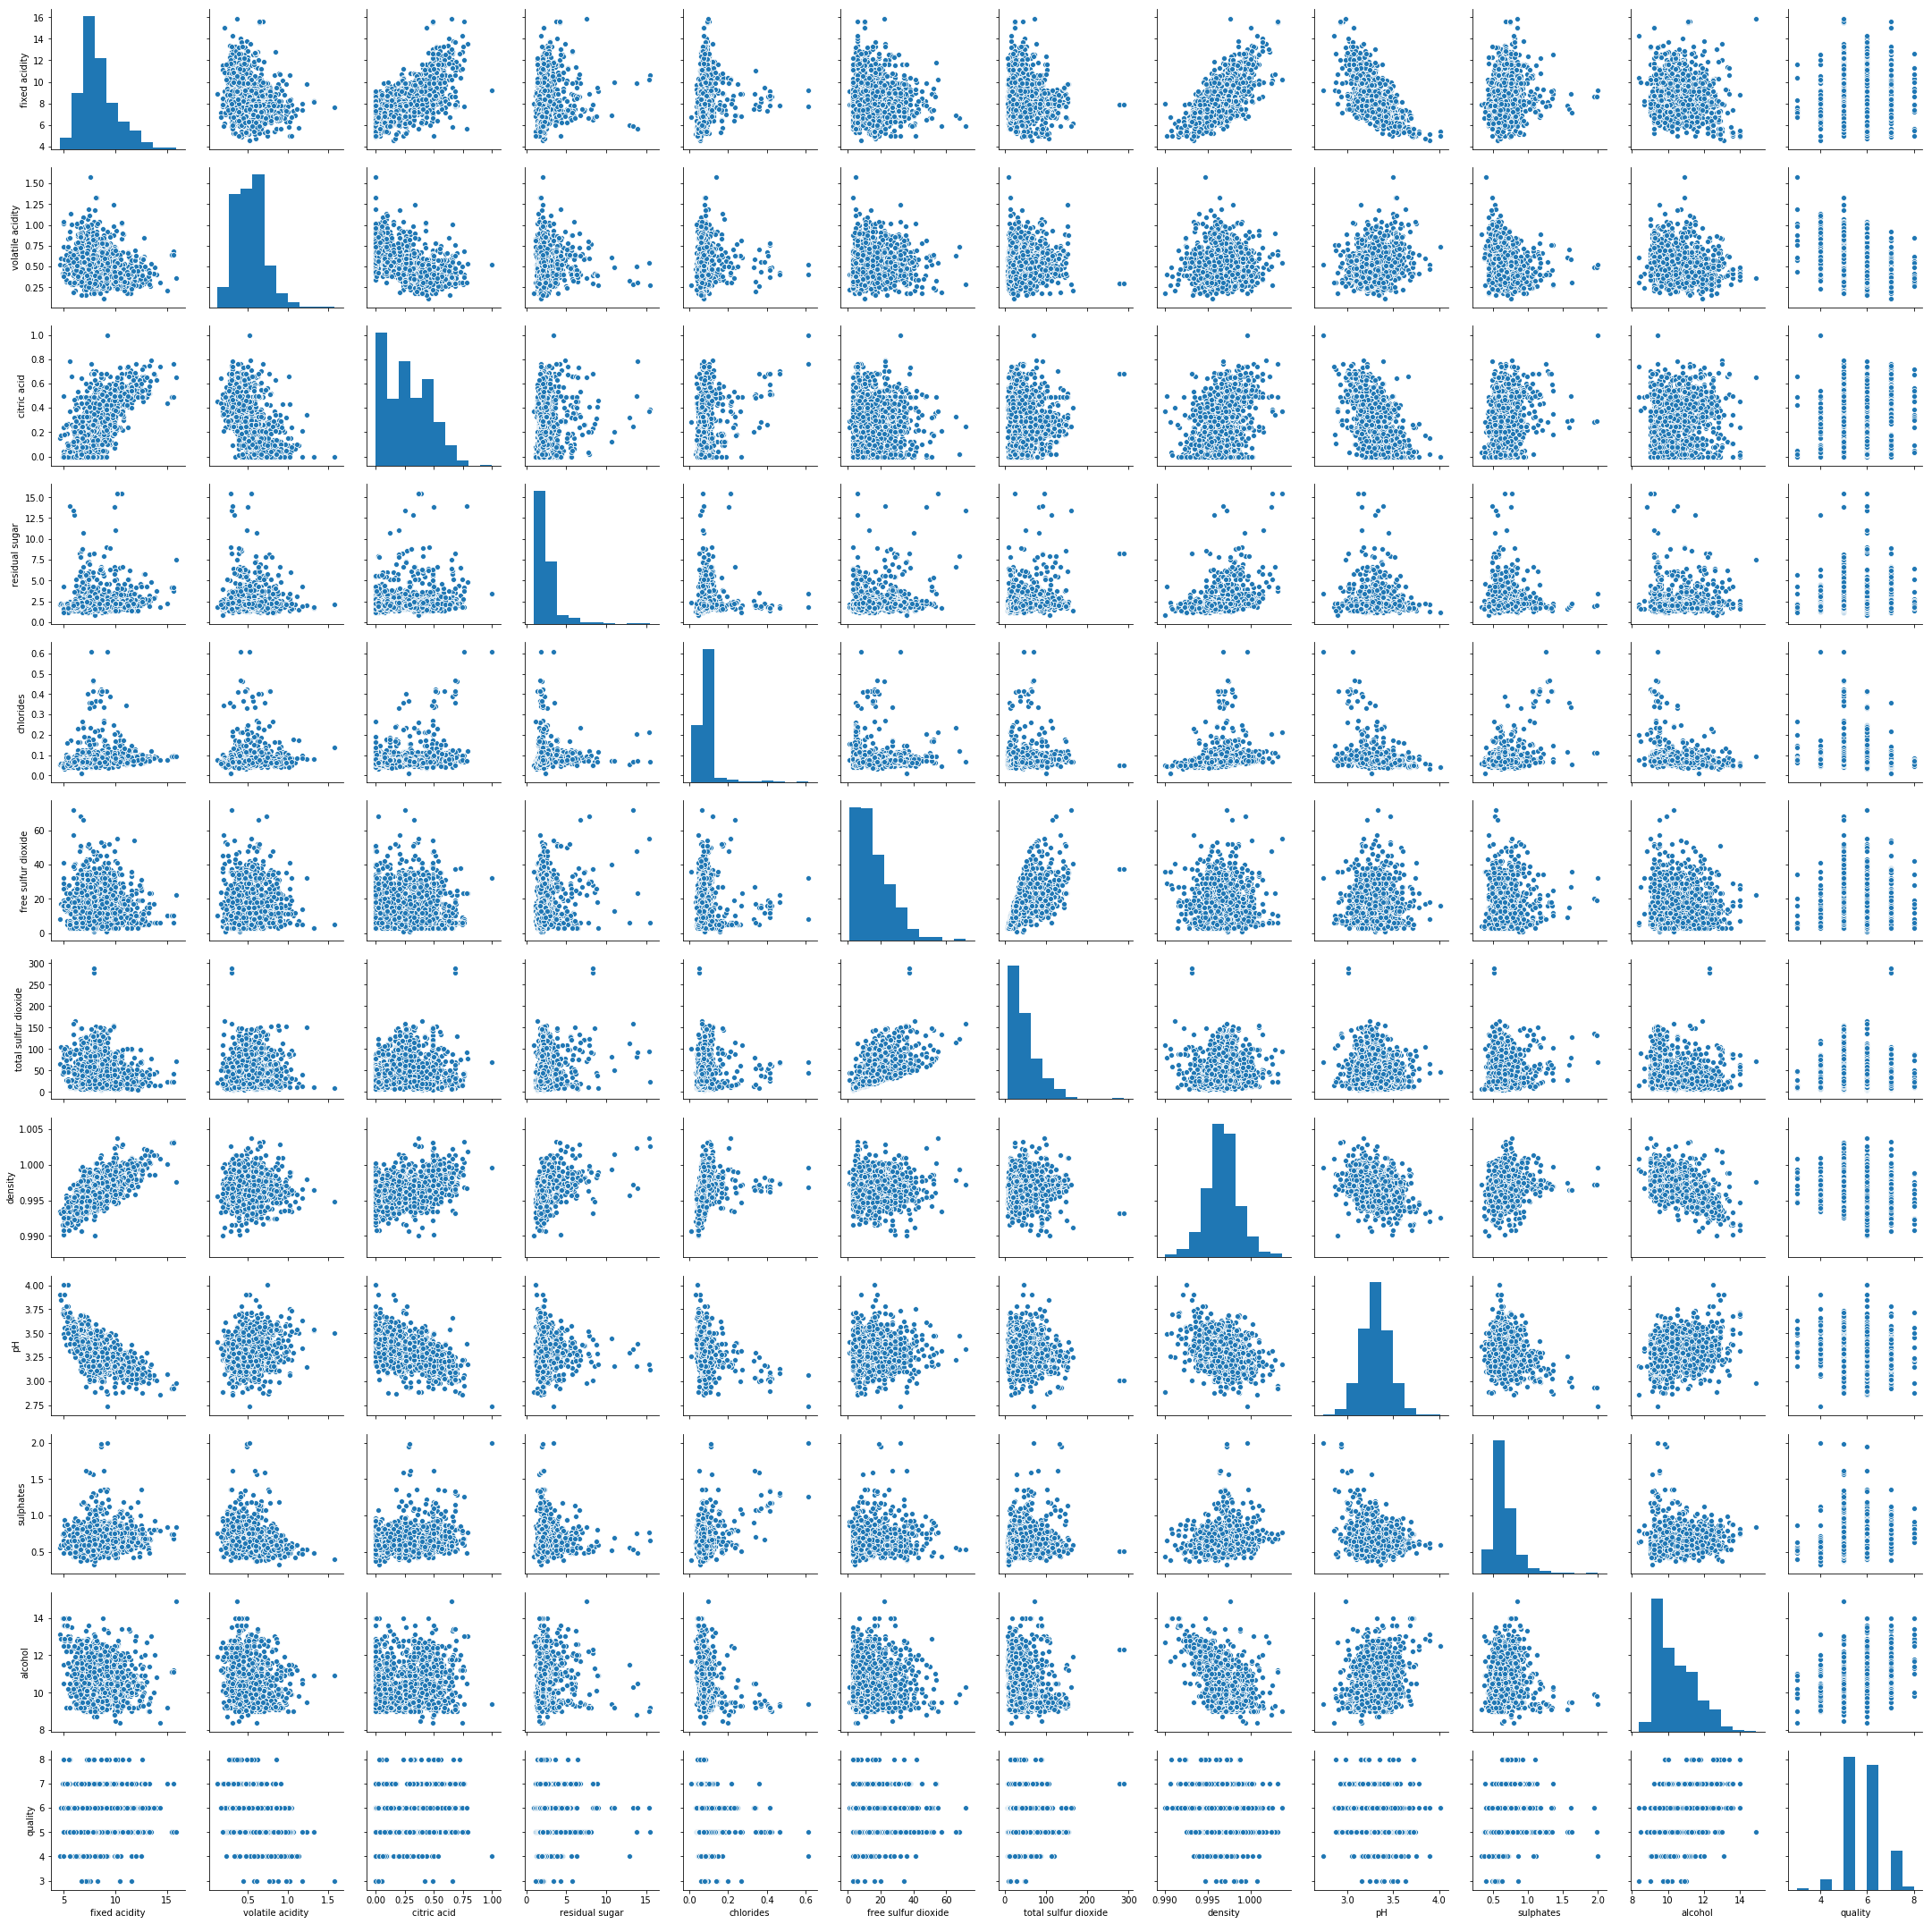

In [6]:
sns.pairplot(wine_data)

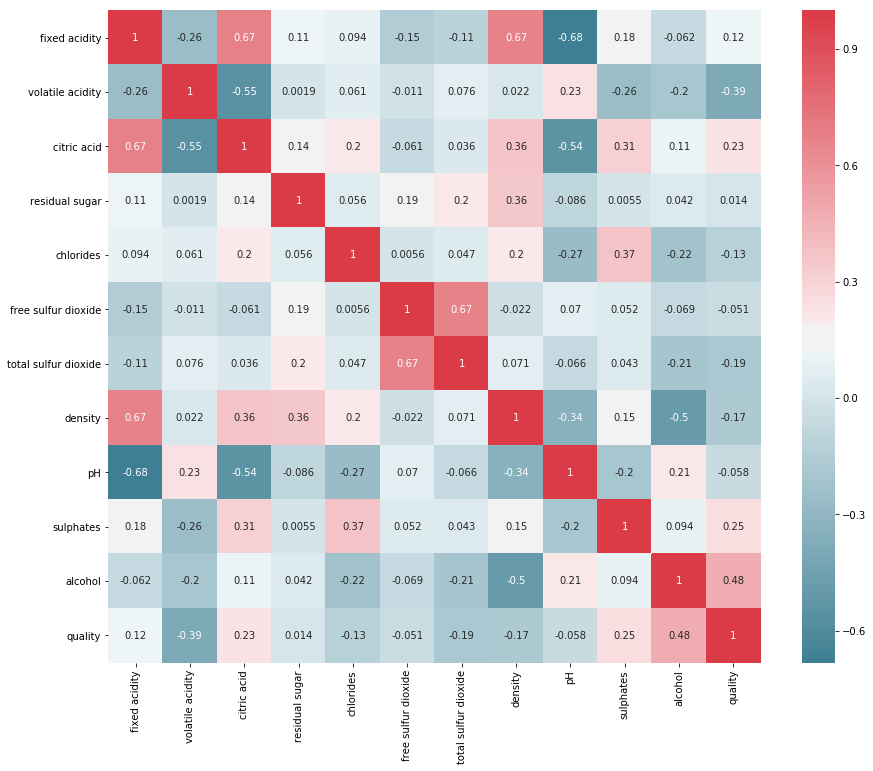

In [7]:
f, ax = subplots(figsize=(15, 12))
corr = wine_data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), annot = True,
            square=True, ax=ax)

look who's significantly *positively* correlated with quality!

# generate training/test data

In [7]:
wine_data.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [8]:
X, y = wine_data[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar','chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol']], wine_data['quality']
X.shape, y.shape

((1599, 11), (1599,))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify = y)

# linear regression

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
predicted = lin_reg.predict(X_test)
lin_reg.score(X_test, y_test) #returns coefficient of determination

0.37025045490789543

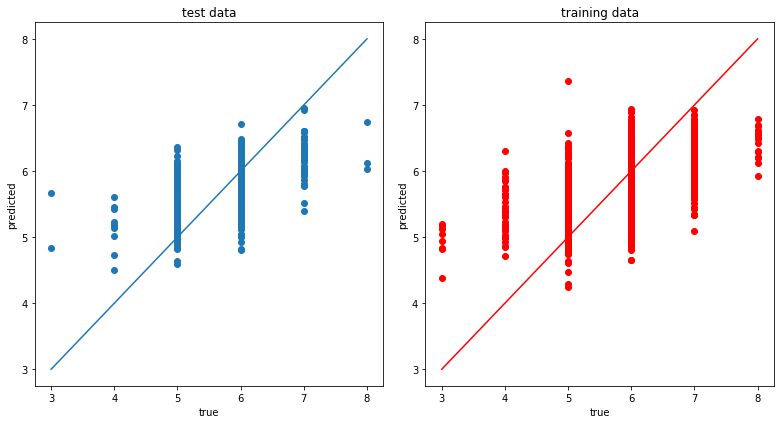

In [14]:
f, ax = subplots(1, 2, figsize=(11, 6))
ax = subplot(121)
scatter(y_test, predicted)
plot(range(3,9), range(3,9))
ax.set_title('test data')
ax.set_xlabel('true')
ax.set_ylabel('predicted')
ax = subplot(122)
ax.scatter(y_train, lin_reg.predict(X_train), c = 'red')
plot(range(3,9), range(3,9), c = 'r')
ax.set_title('training data')
ax.set_xlabel('true')
ax.set_ylabel('predicted')
tight_layout()
show()

*regression to the mean*

most predictions are around 5.5

Why could regression (MSE objective function) be useful in that classification problem?

&rarr; miscalssifications are penalized according to "how far they are". This is not seen in accuracy score but may be relevant

(Text(0.5, 15.0, 'predicted'), Text(33.0, 0.5, 'true'))

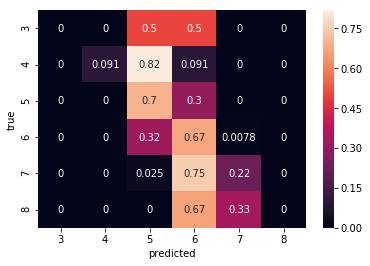

In [16]:
cm = confusion_matrix(y_test, around(predicted))
cm = cm.astype(float)/(cm.sum(axis=1)+.0000001)[:, newaxis]
sns.heatmap(cm, annot = True, xticklabels=range(3,9), yticklabels=range(3,9))
xlabel('predicted'), ylabel('true')

In [17]:
accuracies = dict()

In [20]:
accuracies['lin_reg']=accuracy_score(np.round(lin_reg.predict(X_test)), y_test)
print('accuracy: ', accuracies['lin_reg'])
print('precision, recall, f1: ',precision_recall_fscore_support(np.round(lin_reg.predict(X_test)), y_test))

accuracy:  0.596875
precision, recall, f1:  (array([0.        , 0.09090909, 0.69852941, 0.671875  , 0.225     ,
       0.        ]), array([0.        , 1.        , 0.6462585 , 0.53416149, 0.81818182,
       0.        ]), array([0.        , 0.16666667, 0.67137809, 0.59515571, 0.35294118,
       0.        ]), array([  0,   1, 147, 161,  11,   0]))


/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# (Multiclass) Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegressionCV

In [22]:
clf = LogisticRegressionCV(Cs = 30, cv=5, random_state=0,
                           multi_class='multinomial').fit(X_train, y_train)

/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Incre

/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Incre

/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Incre

/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Incre

In [23]:
print('accuracy: ',accuracy_score(np.round(clf.predict(X_test)), y_test))

accuracy:  0.5875


/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Incre

/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/herfurtht/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Incre

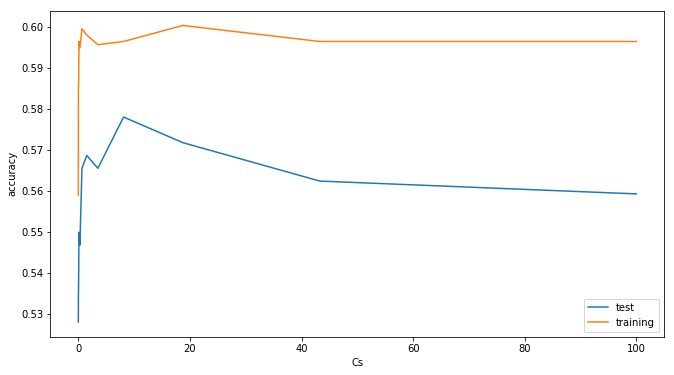

In [24]:
score_test, score_train = [], []
for d in logspace(-2,2,12):
        clf = LogisticRegressionCV(penalty = 'l2', Cs = [d], cv=5, random_state=0,
                               multi_class='multinomial').fit(X_train, y_train)
        score_test.append(clf.score(X_test, y_test))
        score_train.append(clf.score(X_train, y_train))
f, ax = subplots(1, 1, figsize=(11, 6))
ax = subplot(111)
plot(logspace(-2,2,12), score_test, label='test')
plot(logspace(-2,2,12), score_train, label='training')
xlabel('Cs')
ylabel('accuracy')
legend()
show()

In [26]:
accuracies['log_reg']= score_test[argmax(score_train)]
print('max accuracy: ', accuracies['log_reg'])

max accuracy:  0.571875


# SVM

In [27]:
from sklearn import svm

In [33]:
clf = svm.SVC(C = 2, gamma='scale', kernel = 'poly', degree = 3)
clf.fit(X_train, y_train)

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

different kernels and values of C did not improve the prediction

In [34]:
predicted_test = clf.predict(X_test)
predicted_train = clf.predict(X_train)

In [35]:
accuracies['svm'] = clf.score(X_test, y_test)
print("accuracy on test data: ", accuracies['svm'])
print('R^2 on test data: ', r2_score(y_test, predicted_test))

accuracy on test data:  0.525
R^2 on test data:  0.041104183061928756


# LDA/QDA

In [36]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

In [37]:
clf = LinearDiscriminantAnalysis() #QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [38]:
predicted_test = clf.predict(X_test)
predicted_train = clf.predict(X_train)

In [40]:
accuracies['lda'] = clf.score(X_test, y_test)
print("accuracy on test data: ", accuracies['lda'])
print('R^2 on test data: ', r2_score(y_test, predicted_test))

accuracy on test data:  0.590625
R^2 on test data:  0.15249107088806835


# decision trees

## simple tree

In [41]:
from sklearn import tree
import graphviz

In [42]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [43]:
predicted_test = clf.predict(X_test)
predicted_train = clf.predict(X_train)

In [44]:
accuracies['simple_tree'] = clf.score(X_test, y_test)
print("accuracy on test data: ", accuracies['simple_tree'])
print('R^2 on test data: ', r2_score(y_test, predicted_test))

accuracy on test data:  0.609375
R^2 on test data:  0.09437617289182154


### feature importances

In [108]:
feature_importance = pd.Series(clf.feature_importances_, wine_data.columns[:-1])
feature_importance.sort_values(ascending=False)

alcohol                 0.181822
sulphates               0.128902
volatile acidity        0.124564
total sulfur dioxide    0.097027
fixed acidity           0.074851
density                 0.072638
citric acid             0.069815
pH                      0.066993
residual sugar          0.066659
chlorides               0.061723
free sulfur dioxide     0.055005
dtype: float64

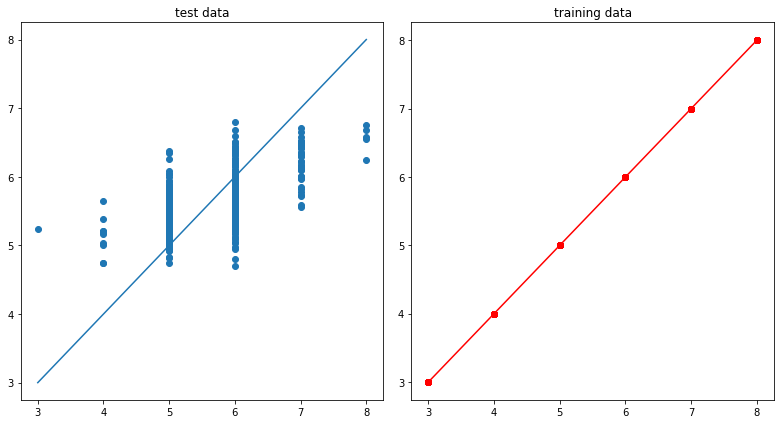

In [27]:
f, ax = subplots(1, 2, figsize=(11, 6))
ax = subplot(121)
scatter(y_test, predicted)
plot(range(3,9), range(3,9))
ax.set_title('test data')
ax = subplot(122)
ax.scatter(y_train, predicted_train, c = 'red')
plot(range(3,9), range(3,9), c = 'r')
ax.set_title('training data')
tight_layout()
show()

that's what one calls overfitting I guess. trees can be regularized by pruning/depth constraints.

### plot the tree

In [28]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("red-wine-tree") 

'red-wine-tree.pdf'

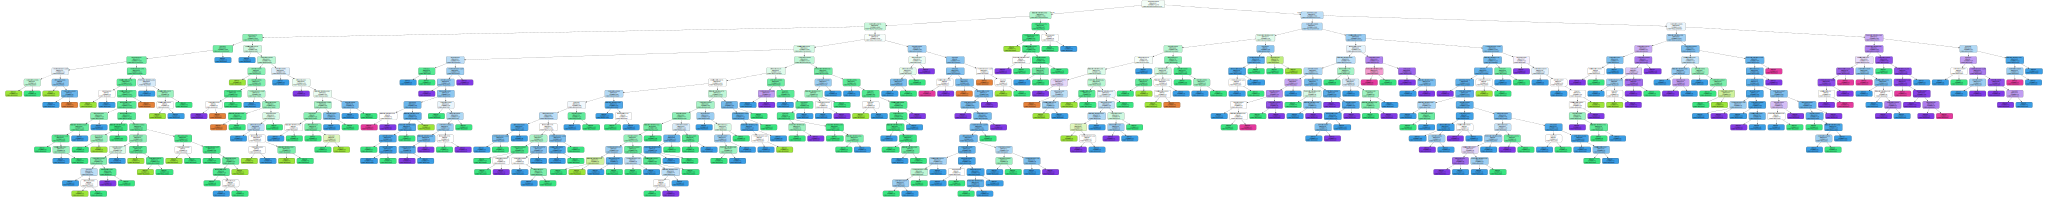

In [29]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names= ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar','chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol'],  
                     class_names= None,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("red-wine-tree") 
graph 

### changing depth

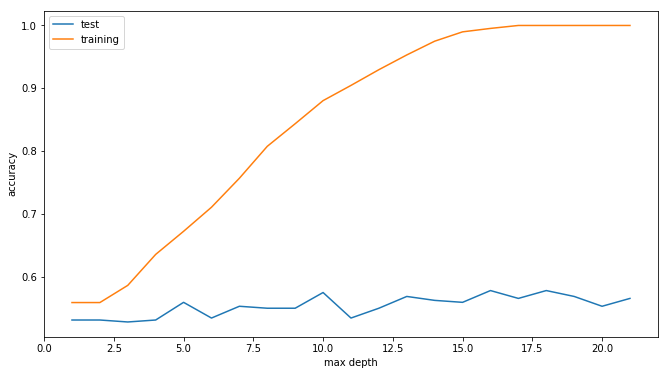

In [30]:
score_test, score_train = [], []
for d in range(1,22):
    clf = tree.DecisionTreeClassifier(max_depth=d)
    clf = clf.fit(X_train, y_train)
    score_test.append(clf.score(X_test, y_test))
    score_train.append(clf.score(X_train, y_train))
f, ax = subplots(1, 1, figsize=(11, 6))
ax = subplot(111)
plot(range(1,22), score_test, label='test')
plot(range(1,22), score_train, label='training')
xlabel('max depth')
ylabel('accuracy')
legend()
show()
#     print('max depth: ', d)
#     print("accuracy on test data: " ,clf.score(X_test, y_test))
#     print('$R^2$ on test data: ', r2_score(y_test, predicted_test))

## random forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
clf = RandomForestClassifier(n_estimators=50, max_depth=4)
clf = clf.fit(X_train, y_train)

In [47]:
feature_importance = pd.Series(clf.feature_importances_, wine_data.columns[:-1])
feature_importance.sort_values(ascending=False)

alcohol                 0.284198
sulphates               0.135148
volatile acidity        0.129243
total sulfur dioxide    0.126758
density                 0.106452
fixed acidity           0.072566
chlorides               0.037086
citric acid             0.032624
pH                      0.025596
free sulfur dioxide     0.025563
residual sugar          0.024767
dtype: float64

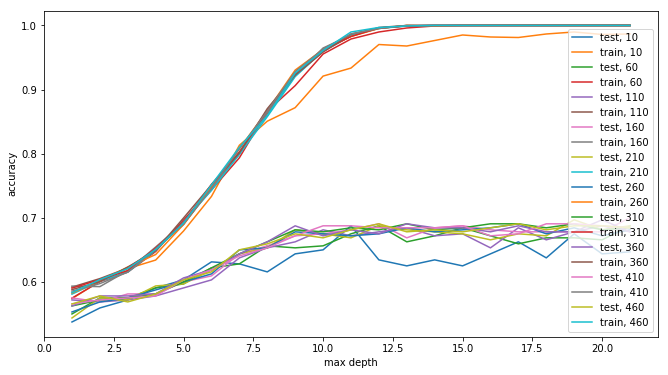

maximum test score:  0.7


In [50]:
max_score = 0
f, ax = subplots(1, 1, figsize=(11, 6))
ax = subplot(111)
for estim in range(10,500,50):
    score_test, score_train = [], []
    for d in range(1,22):
        clf = RandomForestClassifier(n_estimators=estim, max_depth=d, )
        clf = clf.fit(X_train, y_train)
        score_test.append(clf.score(X_test, y_test))
        score_train.append(clf.score(X_train, y_train))
    plot(range(1,22), score_test, label='test, {}'.format(estim))
    plot(range(1,22), score_train, label='train, {}'.format(estim))
    max_score = max(max_score, max(score_test))
xlabel('max depth')
ylabel('accuracy')
legend()
show()
print('maximum test score: ', max_score)

In [51]:
#predicted_test = clf.predict(X_test)
#predicted_train = clf.predict(X_train)
accuracies['random_forest'] = score_test[argmax(score_train)]#clf.score(X_test, y_test)
print("accuracy on test data: ", accuracies['random_forest'])
print(r'R^2 on test data: ', r2_score(y_test, predicted_test))

accuracy on test data:  0.68125
R^2 on test data:  0.20092015255160733


## Gradient boosted trees

In [52]:
from sklearn import ensemble

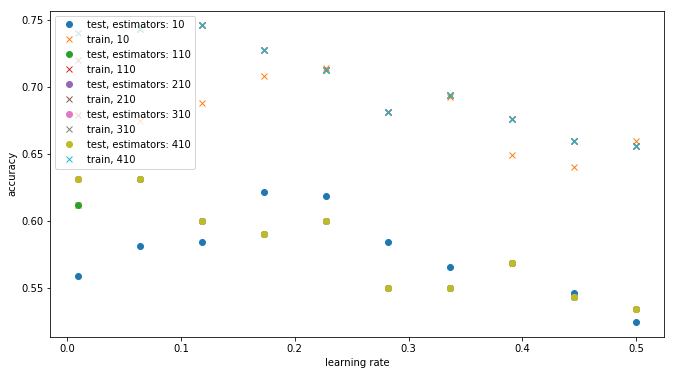

maximum test score:  0.63125


In [53]:
max_score = 0
f, ax = subplots(1, 1, figsize=(11, 6))
ax = subplot(111)
for estim in range(10,500,100):
    score_test, score_train = [], []
    for d in linspace(0.01, .7, 10):
        clf = ensemble.GradientBoostingClassifier(n_estimators= estim, learning_rate=d, subsample = .3, max_features = None, 
                                               validation_fraction=0.2,
                                               n_iter_no_change= 10, tol= .01,
                                               random_state=0)
        clf = clf.fit(X_train, y_train)
        score_test.append(clf.score(X_test, y_test))
        score_train.append(clf.score(X_train, y_train))
    plot(linspace(0.01, .5, 10), score_test, 'o', label='test, estimators: {}'.format(estim))
    plot(linspace(0.01, .5, 10), score_train, 'x', label='train, {}'.format(estim))
    max_score = max(max_score, max(score_test))
xlabel('learning rate')
ylabel('accuracy')
legend()
show()
print('maximum test score: ', max_score)

In [55]:
accuracies['boosted_trees'] = score_test[argmax(score_train)]#clf.score(X_test, y_test)
print("accuracy on test data: ", accuracies['boosted_trees'])
print(r'R^2 on test data: ', r2_score(y_test, predicted_test))

accuracy on test data:  0.6
R^2 on test data:  0.20092015255160733


#    Nearest Neighbors

In [56]:
from sklearn.neighbors import KNeighborsClassifier

In [57]:
clf = KNeighborsClassifier(n_neighbors=15, weights = 'distance')
clf = clf.fit(X_train, y_train)

In [58]:
predicted_test = clf.predict(X_test)
predicted_train = clf.predict(X_train)
print("accuracy on test data: " ,clf.score(X_test, y_test))
print(r'R^2 on test data: ', r2_score(y_test, predicted_test))

accuracy on test data:  0.609375
R^2 on test data:  0.09921908105817545


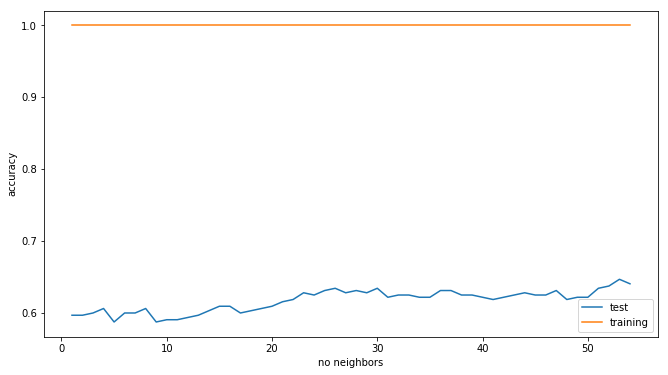

maximum test score:  0.646875


In [59]:
score_test, score_train = [], []
for d in range(1,55):
    clf = KNeighborsClassifier(n_neighbors=d, weights = 'distance')
    clf = clf.fit(X_train, y_train)
    score_test.append(clf.score(X_test, y_test))
    score_train.append(clf.score(X_train, y_train))
f, ax = subplots(1, 1, figsize=(11, 6))
ax = subplot(111)
plot(range(1,55), score_test, label='test')
plot(range(1,55), score_train, label='training')
xlabel('no neighbors')
ylabel('accuracy')
legend()
show()
print('maximum test score: ', amax(score_test))

again, big time overfitting. k-fold would be better here fore validation.

In [60]:
accuracies['nn'] = score_test[argmax(score_train)]#clf.score(X_test, y_test)
print("accuracy on test data: ", accuracies['nn'])
print(r'R^2 on test data: ', r2_score(y_test, predicted_test))

accuracy on test data:  0.596875
R^2 on test data:  0.09921908105817545


# Neural networks

In [64]:
import tensorflow as tf
import keras
from keras.utils import plot_model
from keras.regularizers import l1

Using TensorFlow backend.


data structure for neural networks

In [65]:
from keras.utils import to_categorical

In [66]:
X_train_dnn, y_train_dnn, X_test_dnn, y_test_dnn = array(X_train), to_categorical(y_train), array(X_test), to_categorical(y_test)

"z-scoring"

In [67]:
X_train_dnn, X_test_dnn = (X_train_dnn-X_train_dnn.mean(axis=0))/X_train_dnn.std(axis=0), (X_test_dnn-X_test_dnn.mean(axis=0))/X_test_dnn.std(axis=0)

build the model

## "naive" DNN

In [68]:
model = keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(keras.layers.Dense(46, activation='relu', input_shape = X_train.shape[1:], kernel_regularizer=l1(.1)))
model.add(keras.layers.Dropout(.2))
# Add another:
model.add(keras.layers.Dense(24, activation='relu',))
model.add(keras.layers.Dropout(.2))
# Add a softmax layer with 10 output units:
model.add(keras.layers.Dense(9, activation='softmax'))

In [69]:
model.compile(optimizer=tf.train.AdamOptimizer(0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [70]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 46)                552       
_________________________________________________________________
dropout_1 (Dropout)          (None, 46)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 225       
Total params: 1,905
Trainable params: 1,905
Non-trainable params: 0
_________________________________________________________________


show the model as a graph

In [71]:
plot_model(model, to_file='model.png', show_shapes=True)
show('model.png')

from PIL import Image
image = Image.open("model.png")
image.show()

In [72]:
learning = model.fit(X_train_dnn, y_train_dnn, epochs = 355, validation_split= .15)

Train on 1087 samples, validate on 192 samples
Epoch 1/355
1087/1087 [==============================] - 2s 2ms/step - loss: 6.7770 - acc: 0.4315 - val_loss: 3.5261 - val_acc: 0.5260
Epoch 2/355
1087/1087 [==============================] - 0s 91us/step - loss: 2.0207 - acc: 0.5106 - val_loss: 1.4533 - val_acc: 0.5052
Epoch 3/355
1087/1087 [==============================] - 0s 80us/step - loss: 1.2820 - acc: 0.4986 - val_loss: 1.3150 - val_acc: 0.5208
Epoch 4/355
1087/1087 [==============================] - 0s 84us/step - loss: 1.2008 - acc: 0.5391 - val_loss: 1.2858 - val_acc: 0.5000
Epoch 5/355
1087/1087 [==============================] - 0s 71us/step - loss: 1.1582 - acc: 0.5575 - val_loss: 1.3104 - val_acc: 0.4948
Epoch 6/355
1087/1087 [==============================] - 0s 115us/step - loss: 1.1848 - acc: 0.5520 - val_loss: 1.2596 - val_acc: 0.5156
Epoch 7/355
1087/1087 [==============================] - 0s 91us/step - loss: 1.1661 - acc: 0.5520 - val_loss: 1.2573 - val_acc: 0.5260
E

1087/1087 [==============================] - 0s 123us/step - loss: 1.1071 - acc: 0.5787 - val_loss: 1.2378 - val_acc: 0.5000
Epoch 61/355
1087/1087 [==============================] - 0s 84us/step - loss: 1.1007 - acc: 0.5833 - val_loss: 1.2331 - val_acc: 0.5417
Epoch 62/355
1087/1087 [==============================] - 0s 105us/step - loss: 1.0873 - acc: 0.5805 - val_loss: 1.2096 - val_acc: 0.5104
Epoch 63/355
1087/1087 [==============================] - 0s 101us/step - loss: 1.0941 - acc: 0.5759 - val_loss: 1.2451 - val_acc: 0.5052
Epoch 64/355
1087/1087 [==============================] - 0s 82us/step - loss: 1.1009 - acc: 0.5695 - val_loss: 1.2674 - val_acc: 0.5052
Epoch 65/355
1087/1087 [==============================] - 0s 89us/step - loss: 1.1078 - acc: 0.5741 - val_loss: 1.1970 - val_acc: 0.5417
Epoch 66/355
1087/1087 [==============================] - 0s 77us/step - loss: 1.0972 - acc: 0.5823 - val_loss: 1.1925 - val_acc: 0.5208
Epoch 67/355
1087/1087 [===========================

1087/1087 [==============================] - 0s 170us/step - loss: 1.0872 - acc: 0.5713 - val_loss: 1.2252 - val_acc: 0.5312
Epoch 120/355
1087/1087 [==============================] - 0s 132us/step - loss: 1.0904 - acc: 0.5925 - val_loss: 1.2516 - val_acc: 0.5104
Epoch 121/355
1087/1087 [==============================] - 0s 92us/step - loss: 1.0901 - acc: 0.5833 - val_loss: 1.2218 - val_acc: 0.5208
Epoch 122/355
1087/1087 [==============================] - 0s 94us/step - loss: 1.0773 - acc: 0.5823 - val_loss: 1.2122 - val_acc: 0.5312
Epoch 123/355
1087/1087 [==============================] - 0s 87us/step - loss: 1.0923 - acc: 0.5805 - val_loss: 1.2360 - val_acc: 0.5052
Epoch 124/355
1087/1087 [==============================] - 0s 127us/step - loss: 1.0719 - acc: 0.5833 - val_loss: 1.2104 - val_acc: 0.5156
Epoch 125/355
1087/1087 [==============================] - 0s 124us/step - loss: 1.1018 - acc: 0.5869 - val_loss: 1.2239 - val_acc: 0.5312
Epoch 126/355
1087/1087 [===================

1087/1087 [==============================] - 0s 104us/step - loss: 1.0757 - acc: 0.5961 - val_loss: 1.2443 - val_acc: 0.5208
Epoch 179/355
1087/1087 [==============================] - 0s 116us/step - loss: 1.0937 - acc: 0.5952 - val_loss: 1.2257 - val_acc: 0.5208
Epoch 180/355
1087/1087 [==============================] - 0s 138us/step - loss: 1.1465 - acc: 0.5731 - val_loss: 1.2975 - val_acc: 0.5312
Epoch 181/355
1087/1087 [==============================] - 0s 49us/step - loss: 1.0876 - acc: 0.6044 - val_loss: 1.2020 - val_acc: 0.5469
Epoch 182/355
1087/1087 [==============================] - 0s 79us/step - loss: 1.0631 - acc: 0.5869 - val_loss: 1.1851 - val_acc: 0.5417
Epoch 183/355
1087/1087 [==============================] - 0s 73us/step - loss: 1.0698 - acc: 0.5777 - val_loss: 1.2093 - val_acc: 0.5000
Epoch 184/355
1087/1087 [==============================] - 0s 85us/step - loss: 1.0916 - acc: 0.5961 - val_loss: 1.2281 - val_acc: 0.5052
Epoch 185/355
1087/1087 [====================

1087/1087 [==============================] - 0s 97us/step - loss: 1.0707 - acc: 0.5796 - val_loss: 1.2169 - val_acc: 0.5156
Epoch 238/355
1087/1087 [==============================] - 0s 80us/step - loss: 1.0897 - acc: 0.5906 - val_loss: 1.2065 - val_acc: 0.5365
Epoch 239/355
1087/1087 [==============================] - 0s 79us/step - loss: 1.0625 - acc: 0.5897 - val_loss: 1.1868 - val_acc: 0.5417
Epoch 240/355
1087/1087 [==============================] - 0s 84us/step - loss: 1.0675 - acc: 0.5814 - val_loss: 1.1983 - val_acc: 0.5469
Epoch 241/355
1087/1087 [==============================] - 0s 93us/step - loss: 1.0843 - acc: 0.5915 - val_loss: 1.2116 - val_acc: 0.5312
Epoch 242/355
1087/1087 [==============================] - 0s 80us/step - loss: 1.0747 - acc: 0.5906 - val_loss: 1.1889 - val_acc: 0.5469
Epoch 243/355
1087/1087 [==============================] - 0s 86us/step - loss: 1.0723 - acc: 0.5952 - val_loss: 1.2134 - val_acc: 0.5260
Epoch 244/355
1087/1087 [=======================

1087/1087 [==============================] - 0s 86us/step - loss: 1.0499 - acc: 0.5980 - val_loss: 1.2017 - val_acc: 0.5260
Epoch 297/355
1087/1087 [==============================] - 0s 59us/step - loss: 1.0674 - acc: 0.5980 - val_loss: 1.2345 - val_acc: 0.4948
Epoch 298/355
1087/1087 [==============================] - 0s 57us/step - loss: 1.0755 - acc: 0.5796 - val_loss: 1.2007 - val_acc: 0.5312
Epoch 299/355
1087/1087 [==============================] - 0s 80us/step - loss: 1.0897 - acc: 0.5860 - val_loss: 1.2044 - val_acc: 0.5365
Epoch 300/355
1087/1087 [==============================] - 0s 82us/step - loss: 1.0665 - acc: 0.5888 - val_loss: 1.2413 - val_acc: 0.5417
Epoch 301/355
1087/1087 [==============================] - 0s 75us/step - loss: 1.0883 - acc: 0.5612 - val_loss: 1.2028 - val_acc: 0.5365
Epoch 302/355
1087/1087 [==============================] - 0s 74us/step - loss: 1.0605 - acc: 0.5851 - val_loss: 1.2031 - val_acc: 0.5312
Epoch 303/355
1087/1087 [=======================

1087/1087 [==============================] - 0s 83us/step - loss: 1.0975 - acc: 0.5741 - val_loss: 1.2385 - val_acc: 0.5417


In [73]:
learning.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

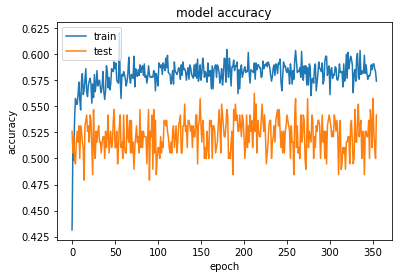

In [74]:
# summarize history for accuracy
plt.plot(learning.history['acc'])
plt.plot(learning.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(learning.history['loss'])
plt.plot(learning.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [81]:
dnn_predict = model.predict(X_test_dnn)
accuracies['naive_dnn'] = accuracy_score(argmax(dnn_predict, axis = 1), y_test)
print('accuracy: ', accuracies['naive_dnn'])

accuracy:  0.56875


(Text(0.5, 15.0, 'predicted'), Text(33.0, 0.5, 'true'))

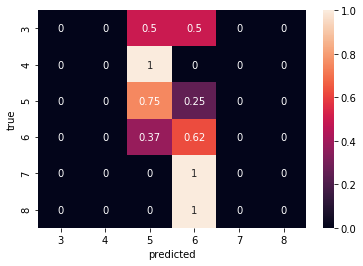

In [76]:
cm = confusion_matrix(y_test, argmax(dnn_predict, axis = 1))
cm = cm.astype(float)/(cm.sum(axis=1)+.0000001)[:, newaxis]
sns.heatmap(cm, annot = True, xticklabels=range(3,9), yticklabels=range(3,9))
xlabel('predicted'), ylabel('true')

### feature importance

In [77]:
input_weights = model.layers[0].get_weights()[0]
relative_importance = abs(input_weights).sum(axis=1)/abs(input_weights).sum()
feature_importance_dnn = pd.Series(relative_importance/relative_importance.sum(), wine_data.columns[:-1])
#print(feature_importance)

In [78]:
importances = pd.DataFrame({'from_dnn':relative_importance/relative_importance.sum(), 'from_tree':feature_importance}, index = wine_data.columns[:-1])

In [79]:
importances

from_dnn  from_tree
fixed acidity         0.090100   0.072566
volatile acidity      0.127380   0.129243
citric acid           0.045845   0.032624
residual sugar        0.040018   0.024767
chlorides             0.068188   0.037086
free sulfur dioxide   0.063631   0.025563
total sulfur dioxide  0.112694   0.126758
density               0.054236   0.106452
pH                    0.068849   0.025596
sulphates             0.158426   0.135148
alcohol               0.170633   0.284198

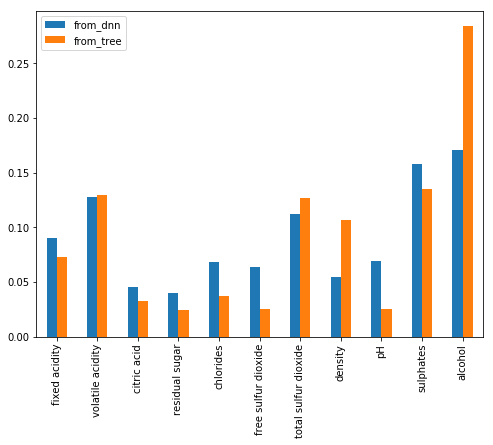

In [80]:
importances.plot(kind='bar', figsize = (8,6))

they agree reasonably well; inparticular for the two most important features. More tweaking could be done on the L1 and training parameters

## w/ bootstrapping for balanced data

*basic approach*: make training data balanced by "stratified" bootstrapping. Still, of course data points are not independent!

551
(3306, 11)


/home/herfurtht/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/herfurtht/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


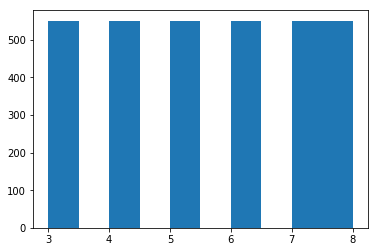

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

num_classes = y_train.nunique()
max_class = max(y_train.value_counts())
print(max_class)
X_, y_ = [], []
for k,cl in enumerate(y_train.unique()):
    X_.append(X_train[y_train==cl].sample(max_class,replace=True).as_matrix())
    y_.append(y_train[y_train==cl].sample(max_class,replace=True).as_matrix())
X_train, y_train = array(X_).reshape(-1, X_train.shape[1]), array(y_).flatten()
print(X_train.shape)

figure()
hist(y_train)
show()

In [83]:
X_train_dnn, y_train_dnn, X_test_dnn, y_test_dnn = array(X_train), to_categorical(y_train), array(X_test), to_categorical(y_test)

In [84]:
learning = model.fit(X_train_dnn, y_train_dnn, epochs = 355, validation_split= .15)

Train on 2810 samples, validate on 496 samples
Epoch 1/355
2810/2810 [==============================] - 0s 119us/step - loss: 2.4816 - acc: 0.1922 - val_loss: 4.1432 - val_acc: 0.0000e+00
Epoch 2/355
2810/2810 [==============================] - 0s 78us/step - loss: 1.8532 - acc: 0.2057 - val_loss: 3.8211 - val_acc: 0.0000e+00
Epoch 3/355
2810/2810 [==============================] - 0s 72us/step - loss: 1.7398 - acc: 0.2310 - val_loss: 3.8986 - val_acc: 0.0000e+00
Epoch 4/355
2810/2810 [==============================] - 0s 143us/step - loss: 1.7300 - acc: 0.2306 - val_loss: 3.8807 - val_acc: 0.0000e+00
Epoch 5/355
2810/2810 [==============================] - 0s 107us/step - loss: 1.7768 - acc: 0.2132 - val_loss: 4.0391 - val_acc: 0.0000e+00
Epoch 6/355
2810/2810 [==============================] - 0s 75us/step - loss: 1.7775 - acc: 0.2484 - val_loss: 3.9329 - val_acc: 0.0000e+00
Epoch 7/355
2810/2810 [==============================] - 0s 78us/step - loss: 1.7306 - acc: 0.2598 - val_loss:

Epoch 59/355
2810/2810 [==============================] - 0s 168us/step - loss: 1.6858 - acc: 0.2648 - val_loss: 3.8166 - val_acc: 0.0000e+00
Epoch 60/355
2810/2810 [==============================] - 0s 88us/step - loss: 1.6727 - acc: 0.2829 - val_loss: 3.8081 - val_acc: 0.0000e+00
Epoch 61/355
2810/2810 [==============================] - 0s 83us/step - loss: 1.6759 - acc: 0.2822 - val_loss: 3.7706 - val_acc: 0.0000e+00
Epoch 62/355
2810/2810 [==============================] - 0s 84us/step - loss: 1.6811 - acc: 0.2804 - val_loss: 3.8789 - val_acc: 0.0000e+00
Epoch 63/355
2810/2810 [==============================] - 0s 156us/step - loss: 1.7007 - acc: 0.2562 - val_loss: 3.9914 - val_acc: 0.0000e+00
Epoch 64/355
2810/2810 [==============================] - 0s 112us/step - loss: 1.7059 - acc: 0.2694 - val_loss: 3.8732 - val_acc: 0.0000e+00
Epoch 65/355
2810/2810 [==============================] - 0s 132us/step - loss: 1.6828 - acc: 0.2790 - val_loss: 3.7414 - val_acc: 0.0000e+00
Epoch 66/

Epoch 117/355
2810/2810 [==============================] - 0s 71us/step - loss: 1.6832 - acc: 0.2644 - val_loss: 3.8627 - val_acc: 0.0000e+00
Epoch 118/355
2810/2810 [==============================] - 0s 93us/step - loss: 1.6811 - acc: 0.2833 - val_loss: 3.8412 - val_acc: 0.0000e+00
Epoch 119/355
2810/2810 [==============================] - 0s 78us/step - loss: 1.6877 - acc: 0.2530 - val_loss: 3.8607 - val_acc: 0.0000e+00
Epoch 120/355
2810/2810 [==============================] - 0s 63us/step - loss: 1.6877 - acc: 0.2569 - val_loss: 3.9075 - val_acc: 0.0000e+00
Epoch 121/355
2810/2810 [==============================] - 0s 69us/step - loss: 1.6729 - acc: 0.2851 - val_loss: 3.8763 - val_acc: 0.0000e+00
Epoch 122/355
2810/2810 [==============================] - 0s 63us/step - loss: 1.6856 - acc: 0.2548 - val_loss: 3.9461 - val_acc: 0.0000e+00
Epoch 123/355
2810/2810 [==============================] - 0s 64us/step - loss: 1.6741 - acc: 0.2701 - val_loss: 3.8874 - val_acc: 0.0000e+00
Epoch 

2810/2810 [==============================] - 0s 74us/step - loss: 1.6749 - acc: 0.2819 - val_loss: 3.8562 - val_acc: 0.0000e+00
Epoch 175/355
2810/2810 [==============================] - 0s 86us/step - loss: 1.6707 - acc: 0.2865 - val_loss: 3.8536 - val_acc: 0.0000e+00
Epoch 176/355
2810/2810 [==============================] - 0s 67us/step - loss: 1.6822 - acc: 0.2630 - val_loss: 3.8881 - val_acc: 0.0000e+00
Epoch 177/355
2810/2810 [==============================] - 0s 71us/step - loss: 1.6973 - acc: 0.2598 - val_loss: 3.8289 - val_acc: 0.0000e+00
Epoch 178/355
2810/2810 [==============================] - 0s 78us/step - loss: 1.6719 - acc: 0.2804 - val_loss: 3.7923 - val_acc: 0.0000e+00
Epoch 179/355
2810/2810 [==============================] - 0s 71us/step - loss: 1.6727 - acc: 0.2769 - val_loss: 3.8256 - val_acc: 0.0000e+00
Epoch 180/355
2810/2810 [==============================] - 0s 64us/step - loss: 1.6686 - acc: 0.2687 - val_loss: 3.8678 - val_acc: 0.0000e+00
Epoch 181/355
2810/2

Epoch 232/355
2810/2810 [==============================] - 0s 56us/step - loss: 1.6782 - acc: 0.2708 - val_loss: 3.9202 - val_acc: 0.0000e+00
Epoch 233/355
2810/2810 [==============================] - 0s 54us/step - loss: 1.6708 - acc: 0.2740 - val_loss: 3.8539 - val_acc: 0.0000e+00
Epoch 234/355
2810/2810 [==============================] - 0s 67us/step - loss: 1.6762 - acc: 0.2737 - val_loss: 3.8786 - val_acc: 0.0000e+00
Epoch 235/355
2810/2810 [==============================] - 0s 48us/step - loss: 1.6818 - acc: 0.2580 - val_loss: 3.9128 - val_acc: 0.0000e+00
Epoch 236/355
2810/2810 [==============================] - 0s 72us/step - loss: 1.6890 - acc: 0.2598 - val_loss: 3.9691 - val_acc: 0.0000e+00
Epoch 237/355
2810/2810 [==============================] - 0s 72us/step - loss: 1.6834 - acc: 0.2598 - val_loss: 3.9223 - val_acc: 0.0000e+00
Epoch 238/355
2810/2810 [==============================] - 0s 90us/step - loss: 1.6858 - acc: 0.2562 - val_loss: 3.8730 - val_acc: 0.0000e+00
Epoch 

Epoch 290/355
2810/2810 [==============================] - 0s 72us/step - loss: 1.6767 - acc: 0.2712 - val_loss: 3.8624 - val_acc: 0.0000e+00
Epoch 291/355
2810/2810 [==============================] - 0s 71us/step - loss: 1.6749 - acc: 0.2690 - val_loss: 3.8373 - val_acc: 0.0000e+00
Epoch 292/355
2810/2810 [==============================] - 0s 77us/step - loss: 1.6768 - acc: 0.2715 - val_loss: 3.7622 - val_acc: 0.0000e+00
Epoch 293/355
2810/2810 [==============================] - 0s 54us/step - loss: 1.6834 - acc: 0.2591 - val_loss: 3.9055 - val_acc: 0.0000e+00
Epoch 294/355
2810/2810 [==============================] - 0s 75us/step - loss: 1.6834 - acc: 0.2623 - val_loss: 3.8780 - val_acc: 0.0000e+00
Epoch 295/355
2810/2810 [==============================] - 0s 61us/step - loss: 1.6790 - acc: 0.2601 - val_loss: 3.8721 - val_acc: 0.0000e+00
Epoch 296/355
2810/2810 [==============================] - 0s 73us/step - loss: 1.6808 - acc: 0.2687 - val_loss: 3.8840 - val_acc: 0.0000e+00
Epoch 

2810/2810 [==============================] - 0s 114us/step - loss: 1.7037 - acc: 0.1861 - val_loss: 3.9972 - val_acc: 0.0000e+00
Epoch 348/355
2810/2810 [==============================] - 0s 110us/step - loss: 1.7037 - acc: 0.1918 - val_loss: 4.0176 - val_acc: 0.0000e+00
Epoch 349/355
2810/2810 [==============================] - 0s 90us/step - loss: 1.7036 - acc: 0.1897 - val_loss: 3.9898 - val_acc: 0.0000e+00
Epoch 350/355
2810/2810 [==============================] - 0s 69us/step - loss: 1.7037 - acc: 0.1797 - val_loss: 4.0024 - val_acc: 0.0000e+00
Epoch 351/355
2810/2810 [==============================] - 0s 95us/step - loss: 1.7033 - acc: 0.1975 - val_loss: 3.9791 - val_acc: 0.0000e+00
Epoch 352/355
2810/2810 [==============================] - 0s 130us/step - loss: 1.7033 - acc: 0.1907 - val_loss: 3.9795 - val_acc: 0.0000e+00
Epoch 353/355
2810/2810 [==============================] - 0s 107us/step - loss: 1.7036 - acc: 0.1758 - val_loss: 3.9578 - val_acc: 0.0000e+00
Epoch 354/355
28

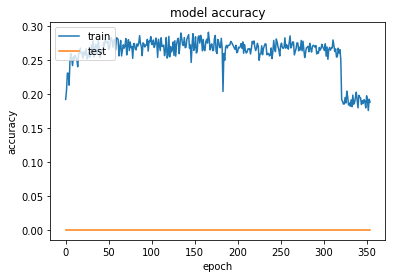

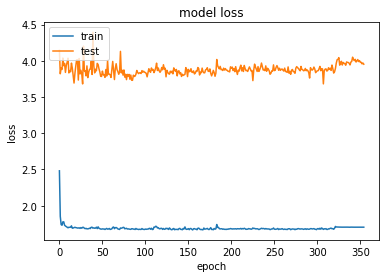

In [85]:
# summarize history for accuracy
plt.plot(learning.history['acc'])
plt.plot(learning.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(learning.history['loss'])
plt.plot(learning.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [86]:
dnn_predict = model.predict(X_test)
accuracies['balanced_dnn'] =accuracy_score(argmax(dnn_predict, axis = 1), y_test)
print('accuracy: ', accuracies['balanced_dnn'])

accuracy:  0.40625


In [87]:
cm = confusion_matrix(y_test, argmax(dnn_predict, axis = 1))
cm = cm.astype(float)/(cm.sum(axis=1)+.00001)[:, newaxis]
sns.heatmap(cm, annot = True, xticklabels=range(3,9), yticklabels=range(3,9))
xlabel('predicted'), ylabel('true')

(Text(0.5, 15.0, 'predicted'), Text(33.0, 0.5, 'true'))

accuracy probably drops because too much weight is given to the oversampled classes.

## hyperparameter optimization

In [89]:
import talos
from talos.model.early_stopper import early_stopper
from talos.model.normalizers import lr_normalizer

In [90]:
from keras.activations import relu, sigmoid, linear
from keras.optimizers import Adam

scan parameter dictionary

In [40]:
p = {}
p['first_neuron'] = [8,16,32]
p['second_neuron'] = [4,8,16]
p['activations1'] = [relu, sigmoid, linear]
p['activations2'] = [relu, sigmoid, linear]
p['dropouts'] = (0., .5, 3)
p['lr'] = (0.1,10, 7) #learning rate, wrapped by lr_normalizer

In [30]:
p

{'first_neuron': [4, 8, 16, 32],
 'second_neuron': [2, 4, 8, 16],
 'activations1': [<function keras.activations.relu(x, alpha=0.0, max_value=None, threshold=0.0)>,
  <function keras.activations.sigmoid(x)>,
  <function keras.activations.linear(x)>],
 'activations2': [<function keras.activations.relu(x, alpha=0.0, max_value=None, threshold=0.0)>,
  <function keras.activations.sigmoid(x)>,
  <function keras.activations.linear(x)>],
 'dropouts': (0.0, 0.5, 3),
 'lr': (0.1, 10, 10)}

stratified validation set for all scans

In [264]:
X_train_dnn, X_val_dnn, y_train_dnn, y_val_dnn = train_test_split(X_train_dnn, y_train_dnn, test_size=0.15, random_state=42, stratify = y_train_dnn)

In [36]:
def optimizable_model(X_train_dnn, y_train_dnn, X_val_dnn, y_val_dnn, p):
    model = keras.Sequential()
    # Adds a densely-connected layer with 64 units to the model:
    model.add(keras.layers.Dense(p['first_neuron'], activation=p['activations1'], input_shape = X_train_dnn.shape[1:]))
    model.add(keras.layers.Dropout(p['dropouts']))
#     # Add another:
    model.add(keras.layers.Dense(p['second_neuron'], activation=p['activations2']))
    model.add(keras.layers.Dropout(p['dropouts']))
#     # Add a softmax layer with 10 output units:
    model.add(keras.layers.Dense(9, activation='softmax'))
    
    model.compile(optimizer=Adam(lr_normalizer(p['lr'], Adam)),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    learning = model.fit(X_train_dnn, y_train_dnn, validation_data=[X_val_dnn, y_val_dnn], epochs = 150, 
                         validation_split= .15, callbacks=early_stopper(monitor = 'val_loss', epochs = 150, patience=3, mode='moderate'), verbose = 0)
    
    return learning, model

In [183]:
early_stopper??

In [53]:
# test basic functionality of network design
#optimizable_model(X_train_dnn, y_train_dnn, X_val_dnn, y_val_dnn, {"first_neuron": 2, 'activations1':relu, 'activations2':relu, 'second_neuron': 2, 'dropouts' : 0, 'lr': 1})

In [41]:
t= talos.Scan(x = X_train_dnn, y = y_train_dnn, x_val = X_val_dnn, y_val = y_val_dnn, params = p, model = optimizable_model, dataset_name='red-wine')






  0%|          | 0/1701 [00:00<?, ?it/s]




  0%|          | 1/1701 [00:05<2:42:33,  5.74s/it]




  0%|          | 2/1701 [00:12<2:50:53,  6.04s/it]




  0%|          | 3/1701 [00:19<3:01:47,  6.42s/it]




  0%|          | 4/1701 [00:29<3:27:17,  7.33s/it]




  0%|          | 5/1701 [00:31<2:47:38,  5.93s/it]




  0%|          | 6/1701 [00:37<2:45:51,  5.87s/it]




  0%|          | 7/1701 [00:42<2:35:57,  5.52s/it]




  0%|          | 8/1701 [00:46<2:24:14,  5.11s/it]




  1%|          | 9/1701 [00:52<2:29:05,  5.29s/it]




  1%|          | 10/1701 [01:01<3:01:52,  6.45s/it]




  1%|          | 11/1701 [01:05<2:45:30,  5.88s/it]




  1%|          | 12/1701 [01:12<2:50:45,  6.07s/it]




  1%|          | 13/1701 [01:20<3:04:45,  6.57s/it]




  1%|          | 14/1701 [01:28<3:16:29,  6.99s/it]




  1%|          | 15/1701 [01:34<3:14:51,  6.93s/it]




  1%|          | 16/1701 [01:40<2:59:17,  6.38s/it]




  1%|          | 17/1701 [01:46<3:01:02,  6.45s/it]




  1%|  

 13%|█▎        | 228/1701 [25:42<2:07:49,  5.21s/it]




 13%|█▎        | 229/1701 [25:47<2:10:13,  5.31s/it]




 14%|█▎        | 230/1701 [25:53<2:17:20,  5.60s/it]




 14%|█▎        | 231/1701 [25:57<2:06:01,  5.14s/it]




 14%|█▎        | 232/1701 [26:04<2:15:33,  5.54s/it]




 14%|█▎        | 233/1701 [26:12<2:35:19,  6.35s/it]




 14%|█▍        | 234/1701 [26:20<2:49:40,  6.94s/it]




 14%|█▍        | 235/1701 [26:28<2:54:17,  7.13s/it]




 14%|█▍        | 236/1701 [26:34<2:44:42,  6.75s/it]




 14%|█▍        | 237/1701 [26:42<2:54:20,  7.15s/it]




 14%|█▍        | 238/1701 [26:45<2:25:00,  5.95s/it]




 14%|█▍        | 239/1701 [26:49<2:09:05,  5.30s/it]




 14%|█▍        | 240/1701 [26:55<2:11:43,  5.41s/it]




 14%|█▍        | 241/1701 [27:05<2:45:31,  6.80s/it]




 14%|█▍        | 242/1701 [27:16<3:16:42,  8.09s/it]




 14%|█▍        | 243/1701 [27:23<3:11:09,  7.87s/it]




 14%|█▍        | 244/1701 [27:26<2:38:22,  6.52s/it]




 14%|█▍        | 245/1701 [27:3

 27%|██▋       | 454/1701 [50:01<2:07:37,  6.14s/it]




 27%|██▋       | 455/1701 [50:05<1:58:18,  5.70s/it]




 27%|██▋       | 456/1701 [50:09<1:47:24,  5.18s/it]




 27%|██▋       | 457/1701 [50:14<1:44:56,  5.06s/it]




 27%|██▋       | 458/1701 [50:20<1:49:06,  5.27s/it]




 27%|██▋       | 459/1701 [50:27<1:58:43,  5.74s/it]




 27%|██▋       | 460/1701 [50:32<1:54:17,  5.53s/it]




 27%|██▋       | 461/1701 [50:40<2:09:44,  6.28s/it]




 27%|██▋       | 462/1701 [50:42<1:44:54,  5.08s/it]




 27%|██▋       | 463/1701 [50:46<1:37:28,  4.72s/it]




 27%|██▋       | 464/1701 [50:55<2:01:57,  5.92s/it]




 27%|██▋       | 465/1701 [50:59<1:51:29,  5.41s/it]




 27%|██▋       | 466/1701 [51:05<1:58:06,  5.74s/it]




 27%|██▋       | 467/1701 [51:09<1:45:13,  5.12s/it]




 28%|██▊       | 468/1701 [51:12<1:34:05,  4.58s/it]




 28%|██▊       | 469/1701 [51:17<1:31:55,  4.48s/it]




 28%|██▊       | 470/1701 [51:22<1:35:47,  4.67s/it]




 28%|██▊       | 471/1701 [51:2

 40%|███▉      | 677/1701 [1:10:56<1:32:36,  5.43s/it]




 40%|███▉      | 678/1701 [1:11:00<1:27:54,  5.16s/it]




 40%|███▉      | 679/1701 [1:11:07<1:36:52,  5.69s/it]




 40%|███▉      | 680/1701 [1:11:15<1:48:45,  6.39s/it]




 40%|████      | 681/1701 [1:11:19<1:32:01,  5.41s/it]




 40%|████      | 682/1701 [1:11:22<1:21:21,  4.79s/it]




 40%|████      | 683/1701 [1:11:30<1:38:06,  5.78s/it]




 40%|████      | 684/1701 [1:11:36<1:38:20,  5.80s/it]




 40%|████      | 685/1701 [1:11:44<1:49:43,  6.48s/it]




 40%|████      | 686/1701 [1:11:51<1:53:22,  6.70s/it]




 40%|████      | 687/1701 [1:11:57<1:48:15,  6.41s/it]




 40%|████      | 688/1701 [1:12:05<1:55:28,  6.84s/it]




 41%|████      | 689/1701 [1:12:13<2:01:30,  7.20s/it]




 41%|████      | 690/1701 [1:12:18<1:53:26,  6.73s/it]




 41%|████      | 691/1701 [1:12:22<1:38:02,  5.82s/it]




 41%|████      | 692/1701 [1:12:26<1:30:46,  5.40s/it]




 41%|████      | 693/1701 [1:12:32<1:29:12,  5.31s/it]



 53%|█████▎    | 897/1701 [1:32:59<1:12:29,  5.41s/it]




 53%|█████▎    | 898/1701 [1:33:03<1:04:26,  4.81s/it]




 53%|█████▎    | 899/1701 [1:33:09<1:09:21,  5.19s/it]




 53%|█████▎    | 900/1701 [1:33:13<1:03:39,  4.77s/it]




 53%|█████▎    | 901/1701 [1:33:19<1:08:39,  5.15s/it]




 53%|█████▎    | 902/1701 [1:33:27<1:19:14,  5.95s/it]




 53%|█████▎    | 903/1701 [1:33:31<1:12:56,  5.48s/it]




 53%|█████▎    | 904/1701 [1:33:38<1:19:08,  5.96s/it]




 53%|█████▎    | 905/1701 [1:33:46<1:27:52,  6.62s/it]




 53%|█████▎    | 906/1701 [1:33:51<1:21:21,  6.14s/it]




 53%|█████▎    | 907/1701 [1:33:54<1:08:16,  5.16s/it]




 53%|█████▎    | 908/1701 [1:34:01<1:14:01,  5.60s/it]




 53%|█████▎    | 909/1701 [1:34:07<1:14:33,  5.65s/it]




 53%|█████▎    | 910/1701 [1:34:13<1:18:41,  5.97s/it]




 54%|█████▎    | 911/1701 [1:34:20<1:23:11,  6.32s/it]




 54%|█████▎    | 912/1701 [1:34:28<1:29:53,  6.84s/it]




 54%|█████▎    | 913/1701 [1:34:34<1:26:04,  6.55s/it]



 66%|██████▌   | 1116/1701 [1:55:34<1:06:07,  6.78s/it]




 66%|██████▌   | 1117/1701 [1:55:41<1:04:43,  6.65s/it]




 66%|██████▌   | 1118/1701 [1:55:49<1:09:09,  7.12s/it]




 66%|██████▌   | 1119/1701 [1:55:54<1:04:12,  6.62s/it]




 66%|██████▌   | 1120/1701 [1:56:03<1:09:10,  7.14s/it]




 66%|██████▌   | 1121/1701 [1:56:10<1:10:45,  7.32s/it]




 66%|██████▌   | 1122/1701 [1:56:17<1:09:41,  7.22s/it]




 66%|██████▌   | 1123/1701 [1:56:24<1:06:48,  6.94s/it]




 66%|██████▌   | 1124/1701 [1:56:29<1:00:44,  6.32s/it]




 66%|██████▌   | 1125/1701 [1:56:37<1:07:13,  7.00s/it]




 66%|██████▌   | 1126/1701 [1:56:44<1:06:07,  6.90s/it]




 66%|██████▋   | 1127/1701 [1:56:51<1:05:51,  6.88s/it]




 66%|██████▋   | 1128/1701 [1:56:59<1:08:21,  7.16s/it]




 66%|██████▋   | 1129/1701 [1:57:05<1:05:39,  6.89s/it]




 66%|██████▋   | 1130/1701 [1:57:11<1:02:52,  6.61s/it]




 66%|██████▋   | 1131/1701 [1:57:19<1:06:37,  7.01s/it]




 67%|██████▋   | 1132/1701 [1:57:23<58:1

 79%|███████▊  | 1339/1701 [2:17:43<43:00,  7.13s/it]




 79%|███████▉  | 1340/1701 [2:17:49<39:58,  6.65s/it]




 79%|███████▉  | 1341/1701 [2:17:53<35:51,  5.98s/it]




 79%|███████▉  | 1342/1701 [2:18:00<37:02,  6.19s/it]




 79%|███████▉  | 1343/1701 [2:18:09<42:15,  7.08s/it]




 79%|███████▉  | 1344/1701 [2:18:16<41:08,  6.92s/it]




 79%|███████▉  | 1345/1701 [2:18:22<39:14,  6.61s/it]




 79%|███████▉  | 1346/1701 [2:18:29<40:27,  6.84s/it]




 79%|███████▉  | 1347/1701 [2:18:32<34:05,  5.78s/it]




 79%|███████▉  | 1348/1701 [2:18:36<31:05,  5.28s/it]




 79%|███████▉  | 1349/1701 [2:18:42<30:55,  5.27s/it]




 79%|███████▉  | 1350/1701 [2:18:48<32:14,  5.51s/it]




 79%|███████▉  | 1351/1701 [2:18:57<38:45,  6.65s/it]




 79%|███████▉  | 1352/1701 [2:19:07<45:01,  7.74s/it]




 80%|███████▉  | 1353/1701 [2:19:17<48:09,  8.30s/it]




 80%|███████▉  | 1354/1701 [2:19:21<41:37,  7.20s/it]




 80%|███████▉  | 1355/1701 [2:19:26<36:24,  6.31s/it]




 80%|███████▉ 

 92%|█████████▏| 1563/1701 [2:43:59<20:22,  8.86s/it]




 92%|█████████▏| 1564/1701 [2:44:07<20:05,  8.80s/it]




 92%|█████████▏| 1565/1701 [2:44:18<21:06,  9.31s/it]




 92%|█████████▏| 1566/1701 [2:44:26<19:49,  8.81s/it]




 92%|█████████▏| 1567/1701 [2:44:35<19:48,  8.87s/it]




 92%|█████████▏| 1568/1701 [2:44:43<19:40,  8.88s/it]




 92%|█████████▏| 1569/1701 [2:44:52<19:18,  8.78s/it]




 92%|█████████▏| 1570/1701 [2:45:05<21:40,  9.93s/it]




 92%|█████████▏| 1571/1701 [2:45:13<20:42,  9.56s/it]




 92%|█████████▏| 1572/1701 [2:45:23<20:52,  9.71s/it]




 92%|█████████▏| 1573/1701 [2:45:27<16:52,  7.91s/it]




 93%|█████████▎| 1574/1701 [2:45:34<16:04,  7.59s/it]




 93%|█████████▎| 1575/1701 [2:45:39<14:15,  6.79s/it]




 93%|█████████▎| 1576/1701 [2:45:42<12:02,  5.78s/it]




 93%|█████████▎| 1577/1701 [2:45:50<13:15,  6.41s/it]




 93%|█████████▎| 1578/1701 [2:45:54<11:32,  5.63s/it]




 93%|█████████▎| 1579/1701 [2:46:02<12:48,  6.30s/it]




 93%|█████████

Scan Finished!


In [54]:
t.data.sort_values('val_acc', ascending = 0).head(7)

round_epochs            val_loss             val_acc                loss  \
567            83   0.927293042341868  0.6614583333333334  0.9734811647945077   
80            132  0.9421655237674713             0.65625  0.9390523216542347   
542            71   1.260089675585429  0.6510416666666666  0.9683518325832862   
85            150  0.9277404050032297  0.6510416666666666  0.9554998051056428   
539            99   0.926789402961731  0.6510416666666666  0.9668800228214527   
1560          145  0.9017480909824371  0.6510416666666666  0.9322002068395009   
225           110  0.9229234655698141  0.6510416666666666  0.9463150914700182   

                     acc first_neuron second_neuron  \
567   0.5942962285347125           16             4   
80    0.6044158229283927           16             4   
542    0.595216190749171           16            16   
85    0.6025758965254489            8             4   
539   0.5970561180294602           16             8   
1560  0.6080956757891145           16            16   
225    0.600735970177339           16             8   

                              activations1  \
567    <function linear at 0x7f2070a321e0>   
80       <function relu at 0x7f2070a25ea0>   
542    <function linear at 0x7f2070a321e0>   
85     <function linear at 0x7f2070a321e0>   
539   <function sigmoid at 0x7f2070a32048>   
1560   <function linear at 0x7f2070a321e0>   
225    <function linear at 0x7f2070a321e0>   

                              activations2             dropouts  \
567    <function linear at 0x7f2070a321e0>                  0.0   
80    <function sigmoid at 0x7f2070a32048>                  0.0   
542    <function linear at 0x7f2070a321e0>                  0.0   
85     <function linear at 0x7f2070a321e0>                  0.0   
539      <function relu at 0x7f2070a25ea0>  0.16666666666666666   
1560     <function relu at 0x7f2070a25ea0>                  0.0   
225   <function sigmoid at 0x7f2070a32048>                  0.0   

                      lr  
567    2.928571428571429  
80     7.171428571428572  
542   4.3428571428571425  
85    1.5142857142857145  
539    7.171428571428572  
1560   2.928571428571429  
225    5.757142857142857

In [55]:
t.details

random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
grid_downsample                    None
reduction_threshold                 0.2
reduction_metric                val_acc
reduce_loss                       False
experiment_name               red-wine_
complete_time            01/18/19/12:03
x_shape                      (1087, 11)
y_shape                       (1087, 9)
dtype: object

from saved file ("red-wine_.csv")

In [57]:
r = talos.Reporting("red-wine_.csv")

In [44]:
data = r.data
acc = pd.to_numeric(data['val_acc'])

In [59]:
figure()
xlabel("round")
ylabel("val_acc")
acc.plot()
show()

In [46]:
r.best_params(n=10)

array([['16', '4', '<function linear at 0x7f2070a321e0>',
        '<function linear at 0x7f2070a321e0>', '0.0',
        '2.928571428571429', 0],
       ['16', '4', '<function relu at 0x7f2070a25ea0>',
        '<function sigmoid at 0x7f2070a32048>', '0.0',
        '7.171428571428572', 1],
       ['16', '16', '<function linear at 0x7f2070a321e0>',
        '<function linear at 0x7f2070a321e0>', '0.0',
        '4.3428571428571425', 2],
       ['8', '4', '<function linear at 0x7f2070a321e0>',
        '<function linear at 0x7f2070a321e0>', '0.0',
        '1.5142857142857145', 3],
       ['16', '8', '<function sigmoid at 0x7f2070a32048>',
        '<function relu at 0x7f2070a25ea0>', '0.16666666666666666',
        '7.171428571428572', 4],
       ['16', '16', '<function linear at 0x7f2070a321e0>',
        '<function relu at 0x7f2070a25ea0>', '0.0', '2.928571428571429',
        5],
       ['16', '8', '<function linear at 0x7f2070a321e0>',
        '<function sigmoid at 0x7f2070a32048>', '0.0',
  

In [61]:
r.correlate("val_acc"), r.correlate("acc")

(first_neuron    -0.010797
 second_neuron    0.183456
 dropouts        -0.158093
 lr               0.348634
 Name: val_acc, dtype: float64, first_neuron     0.033585
 second_neuron    0.173949
 dropouts        -0.395565
 lr               0.373338
 Name: acc, dtype: float64)

I don't think these numbers are very informative b/c I'd expect a highly non-linear (possibly non-convex) relation

In [63]:
r.plot_corr(['val_acc'])
tight_layout()
show()

In [65]:
r.plot_kde('val_acc')
show()

does this imply a local maximum with small fluctuations around that?

### save best model

In [67]:
talos.Deploy(t, 'red-wine-best-dnn')

Deploy package red-wine-best-dnn have been saved.


### ...and restore

In [91]:
wine_dnn = talos.Restore('red-wine-best-dnn.zip')

test data accuracy

In [92]:
dnn_predict = wine_dnn.model.predict(X_test_dnn)
accuracies['optimized_dnn'] = accuracy_score(argmax(dnn_predict, axis = 1), y_test)
print('accuracy: ', accuracies['optimized_dnn'])

accuracy:  0.56875


### hyperas (old; not functional)

In [4]:
def data_gen():
    from numpy import array
    wine_data = pd.read_csv('winequality-red.csv')
    X, y = wine_data[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar','chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol']], wine_data['quality']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    X_train_dnn, y_train_dnn, X_test_dnn, y_test_dnn = array(X_train), to_categorical(y_train), array(X_test), to_categorical(y_test)
    return X_train_dnn, y_train_dnn, X_test_dnn, y_test_dnn

In [7]:
def optimizable_model(X_train_dnn, y_train_dnn,X_test_dnn, y_test_dnn):
    import numpy as np
    model = keras.Sequential()
    # Adds a densely-connected layer with 64 units to the model:
    model.add(keras.layers.Dense({{choice([4,8,16,32])}}, activation={{choice(['relu', 'sigmoid'])}}, input_shape = X_train_dnn.shape[1:]))
    model.add(keras.layers.Dropout({{uniform(0., .5)}}))
    # Add another:
    model.add(keras.layers.Dense(24, activation={{choice(['relu', 'sigmoid'])}}))
    model.add(keras.layers.Dropout(.2))
    # Add a softmax layer with 10 output units:
    model.add(keras.layers.Dense(9, activation='softmax'))
    
    model.compile(optimizer=tf.train.AdamOptimizer(0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    learning = model.fit(X_train_dnn, y_train_dnn,epochs = 55, validation_split= .15, verbose = 2)
    validation_acc = np.amax(learning.history['val_acc'])
    
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

In [8]:
best_run, best_model = optim.minimize(model=optimizable_model,
                                  data= data_gen,
                                          algo=tpe.suggest,
                                          max_evals=5,
                                          trials=Trials(),
                                         notebook_name='wine-quality')

>>> Imports:
#coding=utf-8

try:
    import seaborn as sns
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from sklearn.linear_model import LinearRegression
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support, r2_score
except:
    pass

try:
    from sklearn import svm
except:
    pass

try:
    from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
except:
    pass

try:
    from sklearn import tree
except:
    pass

try:
    import graphviz
except:
    pass

try:
    from sklearn import tree
except:
    pass

try:
    from sklearn.ensemble import RandomForestClassifier
except:
    pass

try:
    from sklearn import ensemble
except:
    pass

try:
    from sklearn.neighbors import KNeighborsClassifier
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    import t

TypeError: 'History' object is not subscriptable

# Ensemble

In [93]:
from sklearn.model_selection import StratifiedKFold
from joblib import dump, load

from hyperopt import Trials, STATUS_OK, tpe, space_eval, hp, fmin
#from hyperas import optim
#from hyperas.distributions import uniform, choice

In [94]:
# has to be run again because validation data generated in "hyperparameter optimization"
X_train_dnn, y_train_dnn, X_test_dnn, y_test_dnn = array(X_train), to_categorical(y_train), array(X_test), to_categorical(y_test)

k-fold splitting on training data for hyperparam optimization

## hyperparamter optimization for random forest

In [95]:
skf = StratifiedKFold(n_splits=6, random_state=666, shuffle=True)
splits = skf.split(X_train, y_train)

In [96]:
for train_index, val_index in skf.split(X_train, y_train):
   print("TRAIN:", train_index, "TEST:", val_index)
   X2_train, X2_val = array(X_train)[train_index], array(X_train)[val_index]
   y2_train, y2_val = y_train[train_index], y_train[val_index]

   X2_train_dnn, X2_val_dnn = array(X_train_dnn)[train_index], array(X_train_dnn)[val_index]
   y2_train_dnn, y2_val_dnn = y_train_dnn[train_index], y_train_dnn[val_index]

TRAIN: [   1    2    3 ... 3303 3304 3305] TEST: [   0    6   20   23   25   34   35   49   50   53   55   56   59   62
   81   85   89   92   94   95  101  121  127  128  134  149  154  159
  164  171  172  181  184  185  187  192  196  200  205  207  211  213
  223  231  233  253  256  259  266  268  269  282  284  294  297  303
  313  320  321  322  340  343  344  351  354  358  368  379  397  398
  401  409  412  426  430  434  435  446  448  459  469  479  482  484
  502  504  511  516  517  525  536  545  551  557  571  574  576  585
  586  600  601  604  606  607  610  613  632  636  640  643  645  646
  652  672  678  679  685  700  705  710  715  722  723  732  735  736
  738  743  747  751  756  758  762  764  774  782  784  804  807  810
  817  819  820  833  835  845  848  854  864  871  872  873  891  894
  895  902  905  909  919  930  948  949  952  960  963  977  981  985
  986  997  999 1010 1020 1030 1033 1035 1053 1055 1062 1067 1068 1076
 1087 1096 1102 1108 1122 11

evaluation function for RandomForest

In [97]:
def evaluate_forest(params):
    acc = array([])
    for train_index, val_index in skf.split(X_train, y_train):
        clf = RandomForestClassifier(**params)
#        print(array(X_train)[train_index], array(X_train)[val_index])
#        print(y_train[train_index], y_train[val_index])
        clf.fit(array(X_train)[train_index], array(y_train)[train_index])
        acc = append(acc,clf.score(array(X_train)[val_index], array(y_train)[val_index]))
    acc_mean, acc_var = mean(acc), var(acc)
    return {'loss': -acc_mean, 'loss_variance': acc_var,'status': STATUS_OK}

In [98]:
search_space = {'n_estimators':hp.choice('n_estimators', range(2,100,10)), 'max_depth': hp.choice('max_depth', range(1,100,10)),
            'criterion': hp.choice('criterion', ["gini", "entropy"]), 'max_features': hp.choice('max_features', range(1,11))}

In [99]:
trials = Trials()
best = fmin(fn=evaluate_forest,
    space= search_space,
    algo=tpe.suggest,
    max_evals=30, trials = trials)

In [33]:
trials.results

[{'loss': -0.680222613947702,
  'loss_variance': 0.0006532829187118472,
  'status': 'ok'},
 {'loss': -0.6785849850532476,
  'loss_variance': 0.0007219068711957316,
  'status': 'ok'},
 {'loss': -0.6755245717888374,
  'loss_variance': 0.0010419431945981712,
  'status': 'ok'},
 {'loss': -0.6778643303667479,
  'loss_variance': 0.0011308514168143597,
  'status': 'ok'},
 {'loss': -0.6778607060222988,
  'loss_variance': 0.0005768979666761461,
  'status': 'ok'},
 {'loss': -0.6848997525566204,
  'loss_variance': 0.0005826540686740633,
  'status': 'ok'},
 {'loss': -0.673205608409526,
  'loss_variance': 0.00056847802092217,
  'status': 'ok'},
 {'loss': -0.6707596715043712,
  'loss_variance': 0.0010047983304411706,
  'status': 'ok'},
 {'loss': -0.6754689967797072,
  'loss_variance': 0.0006645838891510481,
  'status': 'ok'},
 {'loss': -0.668510880117485,
  'loss_variance': 0.0007566307717338838,
  'status': 'ok'},
 {'loss': -0.6707700222162046,
  'loss_variance': 0.0004925793087851702,
  'status': 

In [34]:
#print(trials.vals)
print(trials.best_trial)
print(best)

{'state': 2, 'tid': 27, 'spec': None, 'result': {'loss': -0.6887466407924299, 'loss_variance': 0.0012184260232915376, 'status': 'ok'}, 'misc': {'tid': 27, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'criterion': [27], 'max_depth': [27], 'max_features': [27], 'n_estimators': [27]}, 'vals': {'criterion': [0], 'max_depth': [3], 'max_features': [4], 'n_estimators': [8]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2019, 2, 10, 12, 18, 30, 186000), 'refresh_time': datetime.datetime(2019, 2, 10, 12, 18, 31, 192000)}
{'criterion': 0, 'max_depth': 3, 'max_features': 4, 'n_estimators': 8}


save (pickle) best parameters for later use

In [115]:
best_forest_params = space_eval(search_space, best)
f = open('best_forest_params.pkl', 'wb')
pickle.dump(best_forest_params, f)
f.close()

load, train and evaluate best random forest

In [116]:
best_forest_params = load('best_forest_params.pkl')
best_forest = RandomForestClassifier(**best_forest_params)
best_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=91, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=92, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [117]:
predicted_test = best_forest.predict(X_test)
accuracies['optimized_forest'] = best_forest.score(X_test, y_test)
print("accuracy on test data: " , accuracies['optimized_forest'])
print(r'R^2 on test data: ', r2_score(y_test, predicted_test))

accuracy on test data:  0.621875
R^2 on test data:  0.26836922249286455


## combining random forest and DNN

I use the hyperparameter-optimized DNN from above. ideally, optimization would also be based on k-fold CV but this is too time-expensive here. 

In [36]:
best_forest = RandomForestClassifier(**best)
best_forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion=0,
            max_depth=3, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=8, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [122]:
 #model has not been saved explicitely, only parameters
best_dnn = talos.Restore('red-wine-best-dnn.zip').model

In [123]:
X_train_dnn, y_train_dnn, X_test_dnn, y_test_dnn = array(X_train), to_categorical(y_train), array(X_test), to_categorical(y_test)

outputs (class predictions) of forest and DNN are inputs of ensemble network

In [124]:
pred_train_forest, pred_train_dnn = best_forest.predict_proba(X_train), best_dnn.predict(X_train_dnn)
pred_test_forest, pred_test_dnn = best_forest.predict_proba(X_test), best_dnn.predict(X_test_dnn)
predicted_input_train, predicted_input_test = concatenate((pred_train_forest, pred_train_dnn), axis =1), concatenate((pred_test_forest, pred_test_dnn), axis =1)

In [57]:
def evaluate_ensemble(params):
    p = params
    acc = array([])
    for train_index, val_index in skf.split(X_train, y_train):
        model = keras.Sequential()
        # Adds a densely-connected layer with 64 units to the model:
        model.add(keras.layers.Dense(p['first_neuron'], activation=p['activations1'], input_shape = predicted_input_test.shape[1:]))
        model.add(keras.layers.Dropout(p['dropouts']))
    #     # Add another:
        model.add(keras.layers.Dense(p['second_neuron'], activation=p['activations2']))
        model.add(keras.layers.Dropout(p['dropouts']))
    #     # Add a softmax layer with 10 output units:
        model.add(keras.layers.Dense(9, activation='softmax'))

        model.compile(optimizer=Adam(lr_normalizer(p['lr'], Adam)),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

        learning = model.fit(array(predicted_input_train)[train_index], array(y_train_dnn)[train_index], epochs = 150, validation_split= .15, callbacks=early_stopper(monitor = 'val_loss', epochs = 150, patience=3, mode='moderate'), verbose = 0)
        
        print(model.metrics_names)
        acc = append(acc,model.evaluate(array(predicted_input_train)[val_index], array(y_train_dnn)[val_index])[0])
    acc_mean, acc_var = mean(acc), var(acc)
    return {'loss': -acc_mean, 'loss_variance': acc_var,'status': STATUS_OK, 'model': model}

In [58]:
search_space_ensemble = {'first_neuron':hp.choice('first_neuron', [8,16,32]), 'second_neuron':hp.choice('second_neuron', [4,8,16]), 'activations1':hp.choice('activations1', [relu, sigmoid, linear]), 'activations2':hp.choice('activations2', [relu, sigmoid, linear]), 'dropouts':hp.choice('dropouts', linspace(0., .5, 3)), 'lr':hp.choice('lr', linspace(0.1,10, 7))}

In [91]:
%%time
trials_ensemble = Trials()
best_ensemble = fmin(fn=evaluate_ensemble,
    space= search_space_ensemble,
    algo=tpe.suggest,
    max_evals=30, trials = trials_ensemble)

['loss', 'acc']
215/215 [==============================] - 0s 245us/step
['loss', 'acc']
215/215 [==============================] - 0s 138us/step
['loss', 'acc']
214/214 [==============================] - 0s 126us/step
['loss', 'acc']
212/212 [==============================] - 0s 111us/step
['loss', 'acc']
212/212 [==============================] - 0s 126us/step
['loss', 'acc']
211/211 [==============================] - 0s 124us/step
['loss', 'acc']
215/215 [==============================] - 0s 91us/step
['loss', 'acc']
215/215 [==============================] - 0s 101us/step
['loss', 'acc']
214/214 [==============================] - 0s 107us/step
['loss', 'acc']
212/212 [==============================] - 0s 105us/step
['loss', 'acc']
212/212 [==============================] - 0s 104us/step
['loss', 'acc']
211/211 [==============================] - 0s 123us/step
['loss', 'acc']
215/215 [==============================] - 0s 110us/step
['loss', 'acc']
215/215 [===========================

In [92]:
print(trials_ensemble.best_trial)
print(best_ensemble)

{'state': 2, 'tid': 6, 'spec': None, 'result': {'loss': -0.5372470969673587, 'loss_variance': 0.06840515986456264, 'status': 'ok', 'model': <keras.engine.sequential.Sequential object at 0x7f3bac7a9a58>}, 'misc': {'tid': 6, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'activations1': [6], 'activations2': [6], 'dropouts': [6], 'first_neuron': [6], 'lr': [6], 'second_neuron': [6]}, 'vals': {'activations1': [0], 'activations2': [0], 'dropouts': [0], 'first_neuron': [2], 'lr': [0], 'second_neuron': [0]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2019, 2, 12, 16, 58, 10, 419000), 'refresh_time': datetime.datetime(2019, 2, 12, 17, 2, 25, 951000)}
{'activations1': 0, 'activations2': 0, 'dropouts': 0, 'first_neuron': 2, 'lr': 0, 'second_neuron': 0}


In [93]:
best_ensemble_params = space_eval(search_space_ensemble, best_ensemble)
print(best_ensemble_params)

{'activations1': <function relu at 0x7f3cb0fb3400>, 'activations2': <function relu at 0x7f3cb0fb3400>, 'dropouts': 0.0, 'first_neuron': 32, 'lr': 0.1, 'second_neuron': 4}


save model

In [94]:
best_ensemble_model = trials_ensemble.best_trial['result']['model']
best_ensemble_model.save('my_ensemble.h5')

load model

In [118]:
best_ensemble_model = keras.models.load_model('my_ensemble.h5')

In [125]:
predicted_test = best_ensemble_model.predict(predicted_input_test)
accuracies['ensemble'] = accuracy_score(argmax(predicted_test, axis = 1), y_test)
print("accuracy on test data: " , accuracy_score(argmax(predicted_test, axis = 1), y_test))

accuracy on test data:  0.628125


# summary

In [151]:
summary = pd.Series(accuracies)
summary.sort_values(inplace=True)
summary.plot(kind='bar', color='green', figsize = (7,4), fontsize=14, alpha = .7)
gca().axhline(y = 0.42, color='k')

# notes and open questions

- how to better deal with unbalanced data? What could be other meaningful scores (except accuracy)?
- k-fold CV should strictly be applied for all validations
- **How much better could a model possibly be? I.e. how noisy/deterministic/arbitrary is the classification?**